In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc

import torch
from torch.autograd import grad
from torch.autograd.forward_ad import dual_level, make_dual, unpack_dual

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_jacobian_general(z, fwd_mode=False, transform=None, normalize_z=False, print_info=False):
    #accepts only flattened z and x as (N_samples, N_dims)
    assert transform is not None, 'transform must be provided for backward and forward mode'
    x = transform(z)
    assert z.shape[0] == x.shape[0], 'z and x must have the same number of samples'
    #assert z.shape[1] == x.shape[1], 'z and x must have the same number of dimensions'
    
    N_samples = z.shape[0]
    x_dim = x.shape[1]
    z_dim = z.shape[1]

    device = z.device

    full_jac_1rray = torch.zeros((N_samples, z_dim, x_dim)).to(device=device)
    if print_info:
        print('Computing Jacobian with backward autodiff')
    print_update_function = tqdm if print_info else lambda x: x

    if not fwd_mode:
        
        for i in print_update_function(range(x_dim)): #loop through all dims of x
            x_grad = grad((x).reshape(N_samples, -1)[:,i].sum(), z, create_graph=True, allow_unused=True)[0]
            #x_grad.detach()
            #print(x_grad.shape)
            full_jac_1rray[:,:,i] = x_grad.detach().to(device=device)
    else:
        for i in print_update_function(range(z_dim)):
            z_grad = torch.zeros_like(z)
            z_grad[:,i] = 1
            with dual_level():
                dual_z = make_dual(z, z_grad)
                dual_x = transform(dual_z)
                x_rec, x_grad = unpack_dual(dual_x)
            assert torch.allclose(x_rec, x), 'transformed x does not match original x'
            x_grad = x_grad.reshape(x_grad.shape[0], -1)
            full_jac_1rray[:,i,:] = x_grad.detach().to(device=device)

    if normalize_z:
        z_mean = z.mean(0)
        z_std = z.std(0)
        full_jac_array = full_jac_array * z_std[None, :, None]

    return full_jac_array

# 1D Perlin Noise

In [36]:
def perlin_noise_1d(z, shape, res, fade=lambda t: 6*t**5 - 15*t**4 + 10*t**3, use_offsets=False):
    # gradients: (batchsize, res)
    # shape: integer (length of output per batch)
    # res: integer (number of grid points per batch)
    if use_offsets:
        gradients = z[...,0]
        offsets = z[...,1]
    else:
        gradients = z.view(z.shape[0], -1)
        offsets = torch.zeros(gradients.shape[0], gradients.shape[1], device=z.device)
    
    device = gradients.device  # Ensure compatibility with tensor device
    delta = res / shape  # Step size between grid points
    d = shape // res  # Number of repetitions per grid cell

    #print(gradients.shape, offsets.shape)

    # Create 1D grid for interpolation
    grid = torch.linspace(0, res, shape, device=device) % 1  # Shape: (shape,)
    grid = grid.unsqueeze(0).expand(gradients.shape[0], -1)  # Expand to (batchsize, shape)

    # Tile gradients across the interpolated points
    def tile_grads(slice1):
        return gradients[:, slice1[0]:slice1[1]].repeat_interleave(d, dim=1)
    
    def tile_offsets(slice1):
        return offsets[:, slice1[0]:slice1[1]].repeat_interleave(d, dim=1)

    # Dot product function
    def dot(grad, shift, offset):
        return (grid + shift) * grad + offset  # Ensure grid has correct shape (batchsize, shape)

    # Compute Perlin noise components
    n0 = dot(tile_grads([0, -1]), 0, tile_offsets([0, -1]))
    n1 = dot(tile_grads([1, None]), -1, tile_offsets([1, None]))

    #print(n0.shape, n1.shape)

    # Apply fade function
    t = fade(grid)

    # Interpolate and return noise
    return np.sqrt(2) * torch.lerp(n0, n1, t)

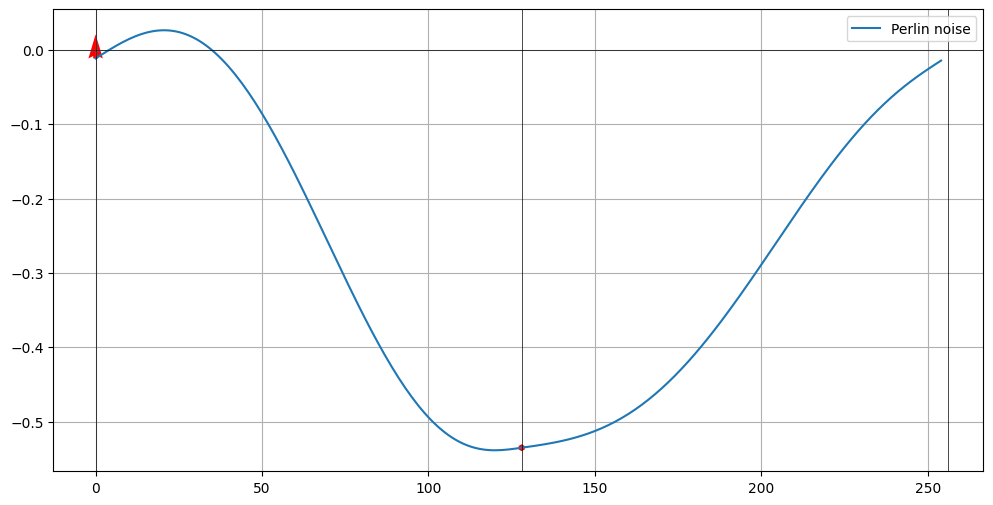

In [65]:
batchsize = 2048
res = 2
resolution = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

fade = lambda t: torch.sin(t * np.pi / 2)**2
#fade = lambda t: 3*t**2 - 2*t**3
#fade = lambda t: t
grads = torch.randn((batchsize, res), device=device)
pts = torch.randn((batchsize, res), device=device)
#add first point at the end to make the arrays periodic
grads = torch.cat([grads, grads[:, 0:1]], dim=1)
pts = torch.cat([pts, pts[:, 0:1]], dim=1) * 0.5

z = torch.stack([grads, pts], dim=-1)
#z = grads

noise_1d = perlin_noise_1d(z, resolution, res, use_offsets=True)[:,:-1] # for use_offsets z contains grads and pts, otherwise only grads

noise_temp = noise_1d[0].cpu().numpy()
plt.figure(figsize=(12, 6))
plt.plot(noise_temp, label='Perlin noise')

grads_temp = grads[0].cpu().numpy()
pts_temp = pts[0].cpu().numpy()
x_array = np.linspace(0, resolution, grads.shape[1])
for i in range(res):
    plt.quiver((i)*resolution/res, noise_temp[int(i*resolution/res)], 0, grads_temp[i], color='red', scale=10)
plt.axhline(0, color="black", linewidth=0.5)
for i in range(res+1):
    plt.axvline(i*resolution/res, color="black", linewidth=0.5)
plt.grid()
plt.legend()
plt.show()

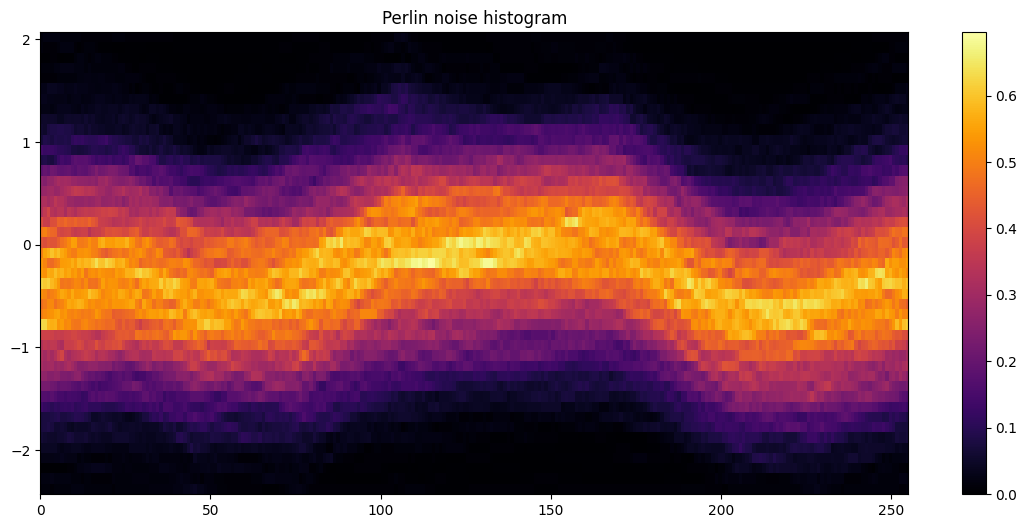

In [66]:
#make a histogramm for each x value over all samples and plot as a bar plot
counts = []
bins = []
for i in range(shape-1):
    hist = np.histogram(noise_1d[:,i].cpu().numpy(), bins=int(np.sqrt(batchsize)), density=True)
    counts.append(hist[0])
    bins.append(hist[1])
#plot hist as 2d heat map
hists = np.array(counts)
bins = np.array(bins)[-1]

plt.figure(figsize=(14, 6))
plt.title('Perlin noise histogram')
#plt.imshow(hists.T, cmap='inferno', interpolation='nearest', aspect='auto')
plt.imshow(hists.T, cmap='inferno', interpolation='nearest', aspect='auto', extent=[0, shape-1, bins[0], bins[-1]])
plt.colorbar()

plt.show()

In [ ]:
np.sqrt(batchsize)

45.254833995939045

In [11]:
def perlin_noise_octaves_1d(z, shapes, resolution, min_freq, octaves=1, persistence=0.5, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3, get_noise_scales=False, use_offsets=False):
    #z is N_samples x z_dim
    N_samples = z.shape[0]
    device = z.device
    noise_sum = torch.zeros(N_samples, resolution).to(device)
    frequency = 1
    amplitude = 1

    noise_scales = []

    fade = lambda t: torch.sin(t * np.pi / 2)**2
    #fade = lambda t : t

    start = 0
    for i in range(octaves):
        end = start + shapes[i][0]

        z_temp = z[:, start:end].reshape(N_samples, *shapes[i])
        
        z_temp = torch.cat([z_temp, z_temp[:, [0]]], dim=1)
        
        noise_scale_temp = amplitude * perlin_noise_1d(z_temp, resolution, frequency*min_freq, fade=fade, use_offsets=use_offsets)
        
        if get_noise_scales:
            noise_scales.append(noise_scale_temp)

        #noise_sum = noise_sum * (1 + noise_scale_temp) + noise_scale_temp #non-linear combination
        noise_sum += noise_scale_temp

        frequency *= 2
        amplitude *= persistence
        start = end
    if get_noise_scales:
        noise_scales = torch.stack(noise_scales, dim=-1)
        return noise_sum, noise_scales
    return noise_sum

In [52]:
def generate_latent_vectors_1d_octaves(batchsize, min_freq, octaves, grads_per_octave=2, use_offsets=False):
    z = []
    grad_shapes = []
    for i in range(octaves):
        z_temp = torch.randn(batchsize, min_freq*grads_per_octave**(i), 1+use_offsets, device=device)
        if use_offsets:
            z_temp[...,1] *= 0.5 #scale the pts to make the noise more isotropic
        z.append(z_temp)
        grad_shapes.append(z[-1].shape[1:])
    z = torch.cat(z, dim=1)

    return z, grad_shapes

In [145]:
batchsize = 1024
min_freq = 1            #must be multiple of 2
grads_per_octave = 2    #only 2 works
octaves = 5             #can't be too large

resolution = 128
use_offsets = True      #Makes the noise more isotropic. If False, the noise is exactly zero at each grid point of the lowest frequency

z, grad_shapes = generate_latent_vectors_1d_octaves(batchsize, min_freq, octaves, grads_per_octave=grads_per_octave, use_offsets=use_offsets)
noise_1d = perlin_noise_octaves_1d(z, grad_shapes, resolution, min_freq, octaves=octaves, use_offsets=use_offsets)[:,:-1]

z_dim = z.shape[1:].numel()
x_dim = noise_1d.shape[1]
print('z_dim:', z_dim, 'x_dim:', x_dim)

z_dim: 62 x_dim: 127


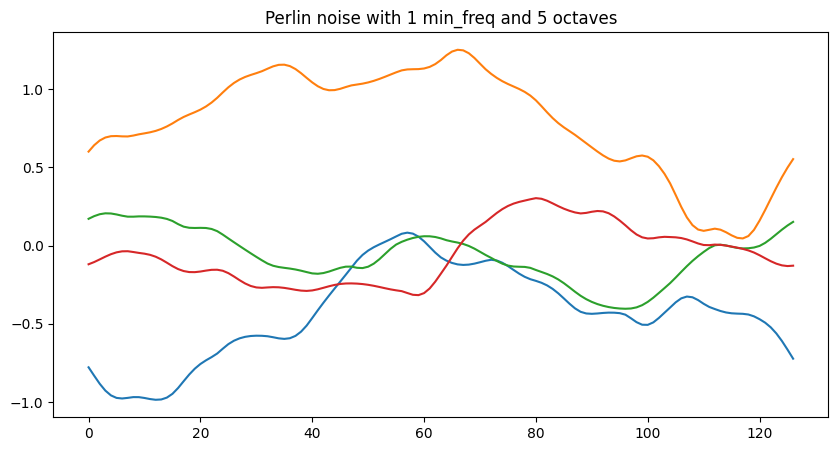

In [146]:
plt.figure(figsize=(10, 5))
plt.title(f'Perlin noise with {min_freq} min_freq and {octaves} octaves')
N_plot = 4
for i in range(N_plot):
    plt.plot(noise_1d[i].cpu().numpy(), label=f'Noise {i}')
#plt.plot(noise_1d[0].T.cpu().numpy())  # Plot for first batch
plt.show()

In [147]:

noise_1d.shape


torch.Size([1024, 127])

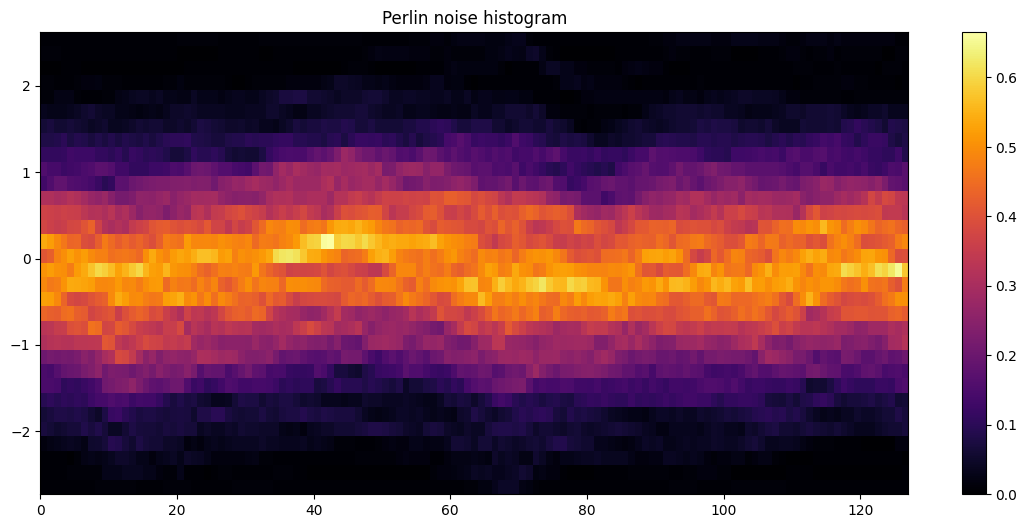

In [150]:
#make a histogramm for each x value over all samples and plot as a bar plot
counts = []
bins = []
for i in range(resolution-1):
    hist = np.histogram(noise_1d[:,i].cpu().numpy(), bins=int(np.sqrt(batchsize)), density=True)
    counts.append(hist[0])
    bins.append(hist[1])
#plot hist as 2d heat map
hists = np.array(counts)
bins = np.array(bins)[-1]

plt.figure(figsize=(14, 6))
plt.title('Perlin noise histogram')
#plt.imshow(hists.T, cmap='inferno', interpolation='nearest', aspect='auto')
plt.imshow(hists.T, cmap='inferno', interpolation='nearest', aspect='auto', extent=[0, resolution-1, bins[0], bins[-1]])
plt.colorbar()


plt.show()

In [151]:
def transform_perlin_1d(input):
    z = input.reshape(-1, sum([grad_shapes[i][0] for i in range(octaves)]), 1+use_offsets)
    x = perlin_noise_octaves_1d(z, grad_shapes, resolution, min_freq, octaves=octaves, use_offsets=True)[:,:-1]
    output = x.reshape(x.shape[0], -1)
    return output

#use fwd_mode if z_dim << x_dim
print('x_dim:', x_dim, 'z_dim:', z_dim)
jacobian = get_jacobian_general(z=z.reshape(z.shape[0], -1), fwd_mode=True, transform=transform_perlin_1d, print_info=True)

x_dim: 127 z_dim: 62
Computing Jacobian with backward autodiff


100%|██████████| 62/62 [00:00<00:00, 79.61it/s]


In [152]:
#take svd of jacobian for one sample
jacobian_test = jacobian[0]
svd = torch.svd(jacobian_test)
eigenvalues = svd.S.cpu().numpy()

eigenvectors = (svd.V.cpu().numpy() * np.sqrt(eigenvalues)).T

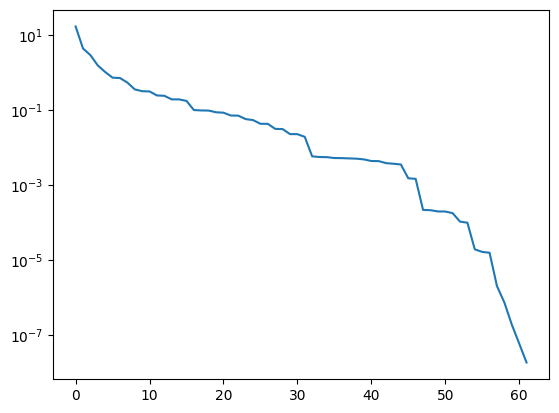

In [153]:
#plot the eigenvalues
plt.plot(eigenvalues)
plt.yscale('log')
plt.show()


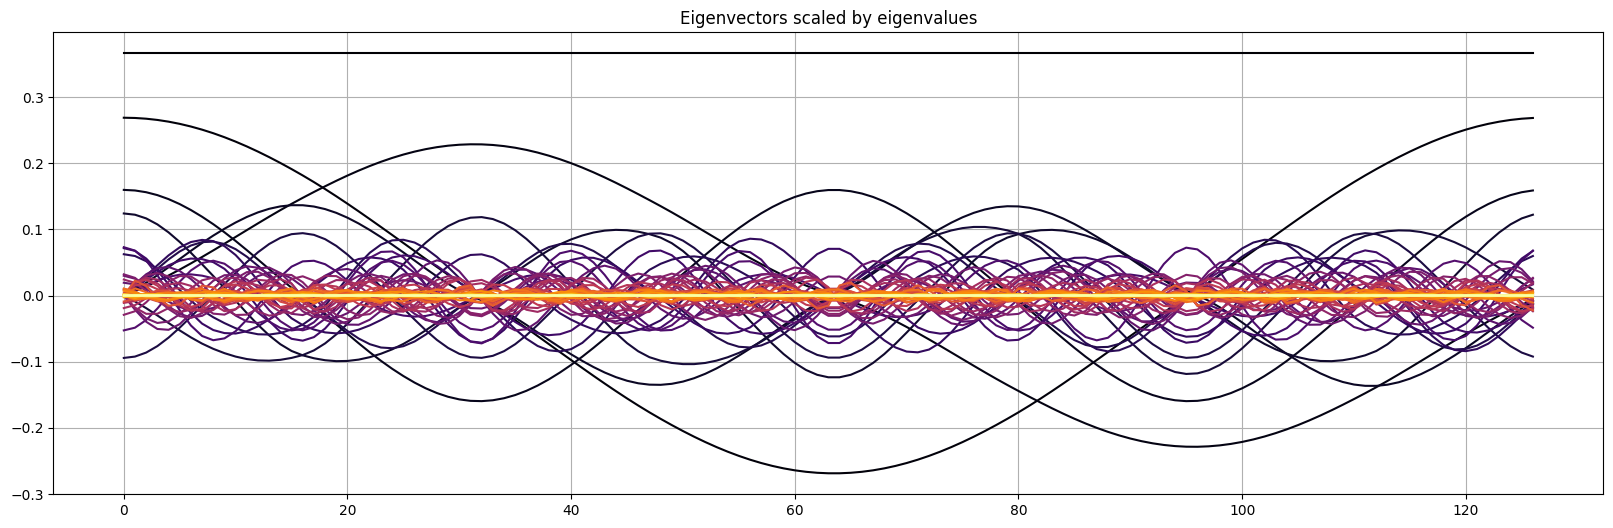

In [154]:
#plot the eigenvectors scaled by the eigenvalues
N_eigenvectors_plot = z_dim

plt.figure(figsize=(20, 6))
plt.title('Eigenvectors scaled by eigenvalues')
colors = plt.cm.inferno(np.linspace(0, 1, N_eigenvectors_plot))
for i in range(N_eigenvectors_plot):
    plt.plot(eigenvectors[i], label=f'eigenvector {i}', color=colors[i])
    
plt.grid()
plt.show()

# 2D Perlin Noise

In [155]:
def perlin_noise_2d(z, shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3, grid=None, use_gradients=False, use_offsets=False):
    #z is angles: (batch, n_angles, n_angles) or gradients: (batch, n_angles, n_angles, 2)
    device = z.device

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    if grid is None:
        grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
        #print(grid.shape)
    if not use_gradients:
        gradients = torch.stack((torch.cos(z), torch.sin(z)), dim = -1)
    else:
        gradients = z[...,0:2]
        
    if use_offsets:
        assert z.shape[-1] == 3, 'z must have 3 dimensions for means'
        means = z[...,-1]
    else:
        means = torch.zeros_like(gradients[...,0])
    #print(gradients.shape, means.shape)

    grid = grid.to(device)
    #gradients = gradients.to(device)

    tile_grads = lambda slice1, slice2: gradients[:, slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 1).repeat_interleave(d[1], 2)
    tile_means = lambda slice1, slice2: means[:, slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 1).repeat_interleave(d[1], 2)
    dot = lambda grad, shift, mean: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad).sum(dim = -1) + mean

    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0], tile_means([0, -1], [0, -1])).to(device)
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0], tile_means([1, None], [0, -1])).to(device)
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1], tile_means([0, -1],[1, None])).to(device)
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1], tile_means([1, None], [1, None])).to(device)
    t = fade(grid[:shape[0], :shape[1]]).to(device)
    return np.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])


def perlin_noise_2d_octaves(z, angle_shapes, resolution, min_freq, octaves=1, persistence=0.5, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3, use_gradients=False, periodic_boundary=False, get_noise_scales=False, attenutate_noise=False, use_offsets=False): #, use_custom_grid=False, grid_jitters=None):
    #z is either angles_flattened : N_samples x z_dim
    #or gradients_flattened : N_samples x z_dim x 2
    N_samples = z.shape[0]
    device = z.device
    noise_sum = torch.zeros(N_samples, resolution, resolution).to(device)
    frequency = 1
    amplitude = 1

    noise_scales = []

    fade = lambda t: torch.sin(t * np.pi / 2)**2
    #fade = lambda t : t

    start = 0
    shape_multiplier = 1
    if use_gradients:
        shape_multiplier = 2
    if use_offsets:
        shape_multiplier = 3
    for i in range(octaves):
        end = start + angle_shapes[i].numel()
        if not use_gradients:
            z_temp = z[:, start:end].reshape(N_samples, *angle_shapes[i])
        else:
            z_temp = z[:, shape_multiplier*start:shape_multiplier*end].reshape(N_samples, *angle_shapes[i], -1)
        
        if use_offsets:
            assert z_temp.shape[-1] == 3, 'z must have 3 dimensions for means'
        if periodic_boundary:
            #print('periodic boundary')
            #print(z_temp.shape)
            #copy the first row and column to the end
            z_temp = torch.cat((z_temp, z_temp[:,[0]]), dim=1)
            #print(z_temp.shape)
            z_temp = torch.cat((z_temp, z_temp[:,:,[0]]), dim=2)
            #print(z_temp.shape)
        
            #transform from polar coordinates to cartesian coordinates
            #radii = torch.sqrt(torch.sum(z_temp**2, dim=-1, keepdim=True))
            #angles = z_temp[..., 0].atan2(z_temp[..., 1])[..., None]
            #radii = z_temp[..., 0].unsqueeze(-1)
            #angles = z_temp[..., 1].unsqueeze(-1)
            #z_temp = torch.cat((radii*torch.cos(angles), radii*torch.sin(angles)), dim=-1)
        grid_points = z_temp.shape[1]

        if attenutate_noise:
            #grid_points = z_temp.shape[1]
            grid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, grid_points), torch.linspace(-1, 1, grid_points)), dim=-1).to(device)
            field_min = 0
            field_max = 1
            #dist = torch.max(grid[..., 0]**2, grid[..., 1]**2)
            #dist = torch.sqrt(grid[..., 0]**2 + grid[..., 1]**2)
            #dist = torch.sqrt(torch.max(grid[..., 0]**2, grid[..., 1]**2))
            dist = torch.max(torch.abs(grid[..., 0]), torch.abs(grid[..., 1]))
            field = field_max - dist * (field_max - field_min)
            z_temp = z_temp * field[..., None]
        
        grid = None
        
        noise_scale_temp = amplitude * perlin_noise_2d(z_temp, (resolution, resolution), (frequency*min_freq[0], frequency*min_freq[1]), fade=fade, grid=grid, use_gradients=use_gradients, use_offsets=use_offsets)
        
        if get_noise_scales:
            noise_scales.append(noise_scale_temp)

        #noise_sum = noise_sum * (1 + noise_scale_temp) + noise_scale_temp #non-linear combination
        noise_sum += noise_scale_temp

        frequency *= 2
        amplitude *= persistence
        start = end
    if get_noise_scales:
        noise_scales = torch.stack(noise_scales, dim=-1)
        return noise_sum, noise_scales
    return noise_sum

In [156]:
persistence = 0.5               #how much does each octave contribute to the overall noise

use_gradients = True            #use gradients instead of angles, default
use_offsets   = False           #use offsets for the noise
periodic_boundary = True        #make the noise periodic at the edges
get_noise_scales = True         #return the noise for each octave individually
attenutate_noise = False        #attenuate the noise towards the edges

octaves = 4               #number of octaves
max_resolution = 64       #resolution of the output image
min_freq = 1              #minimum frequency of the noise, default is 1
max_freq = min_freq * 2**octaves


def generate_latent_vectors(N_samples, min_freq, max_resolution, octaves, periodic_boundary, use_offsets):
    angles_flattened = []
    angle_shapes = []
    gradients = []
    gradients_flattened = []

    for i in range(octaves):
        #angle_temp = 2*torch.pi*torch.rand(N_samples, min_freq*2**i+1, min_freq*2**i+1)
        #gradients_temp = torch.stack((torch.cos(angle_temp), torch.sin(angle_temp)), dim = -1)

        if not periodic_boundary:
            gradients_temp = torch.randn(N_samples, min_freq*2**i+1, min_freq*2**i+1, 2+use_offsets*1)
        else:
            gradients_temp = torch.randn(N_samples, min_freq*2**i, min_freq*2**i, 2+use_offsets*1)

        if use_offsets:
            gradients_temp[...,0:2] *= 1
            gradients_temp[...,-1]  *= 0.4 #1/3.5 #np.sqrt(2)
            #grad_abs = torch.linalg.norm(gradients_temp[...,0:2], dim=-1, keepdim=True)
            #gradients_temp[...,-1] = grad_abs.squeeze(-1)

        angle_temp = gradients_temp[..., 0].atan2(gradients_temp[..., 1])

        gradients.append(gradients_temp)
        gradients_flattened.append(gradients_temp.reshape(N_samples, -1))
        angle_shapes.append(angle_temp.shape[1:])
        angles_flattened.append(angle_temp.reshape(N_samples, -1))

    z = torch.cat(gradients_flattened, dim=-1).to(device).requires_grad_(True)
    x_dim = max_resolution**2
    z_dim = z.shape[1]
    
    return z, gradients, angle_shapes, x_dim, z_dim

In [168]:
N_samples = 16
z, gradients, angle_shapes, x_dim, z_dim = generate_latent_vectors(N_samples, min_freq, max_resolution, octaves, periodic_boundary, use_offsets)
print('x_dim:', x_dim, 'z_dim:', z_dim)

noise_2d, noise_2d_scales = perlin_noise_2d_octaves(z, angle_shapes, max_resolution, (min_freq, min_freq), octaves=octaves, persistence=persistence, use_gradients=use_gradients, periodic_boundary=periodic_boundary, get_noise_scales=True, attenutate_noise=attenutate_noise, use_offsets=use_offsets)
noise_2d, noise_scales = noise_2d.detach(), noise_2d_scales.detach()

x_dim: 4096 z_dim: 170


In [169]:
def transform_perlin_2d(input):
    z = input
    x = perlin_noise_2d_octaves(z, angle_shapes, max_resolution, (min_freq, min_freq), octaves=octaves, persistence=persistence, use_gradients=True, periodic_boundary=periodic_boundary, attenutate_noise=attenutate_noise, use_offsets=use_offsets)
    output = x.reshape(input.shape[0], -1) #flatten output
    return output

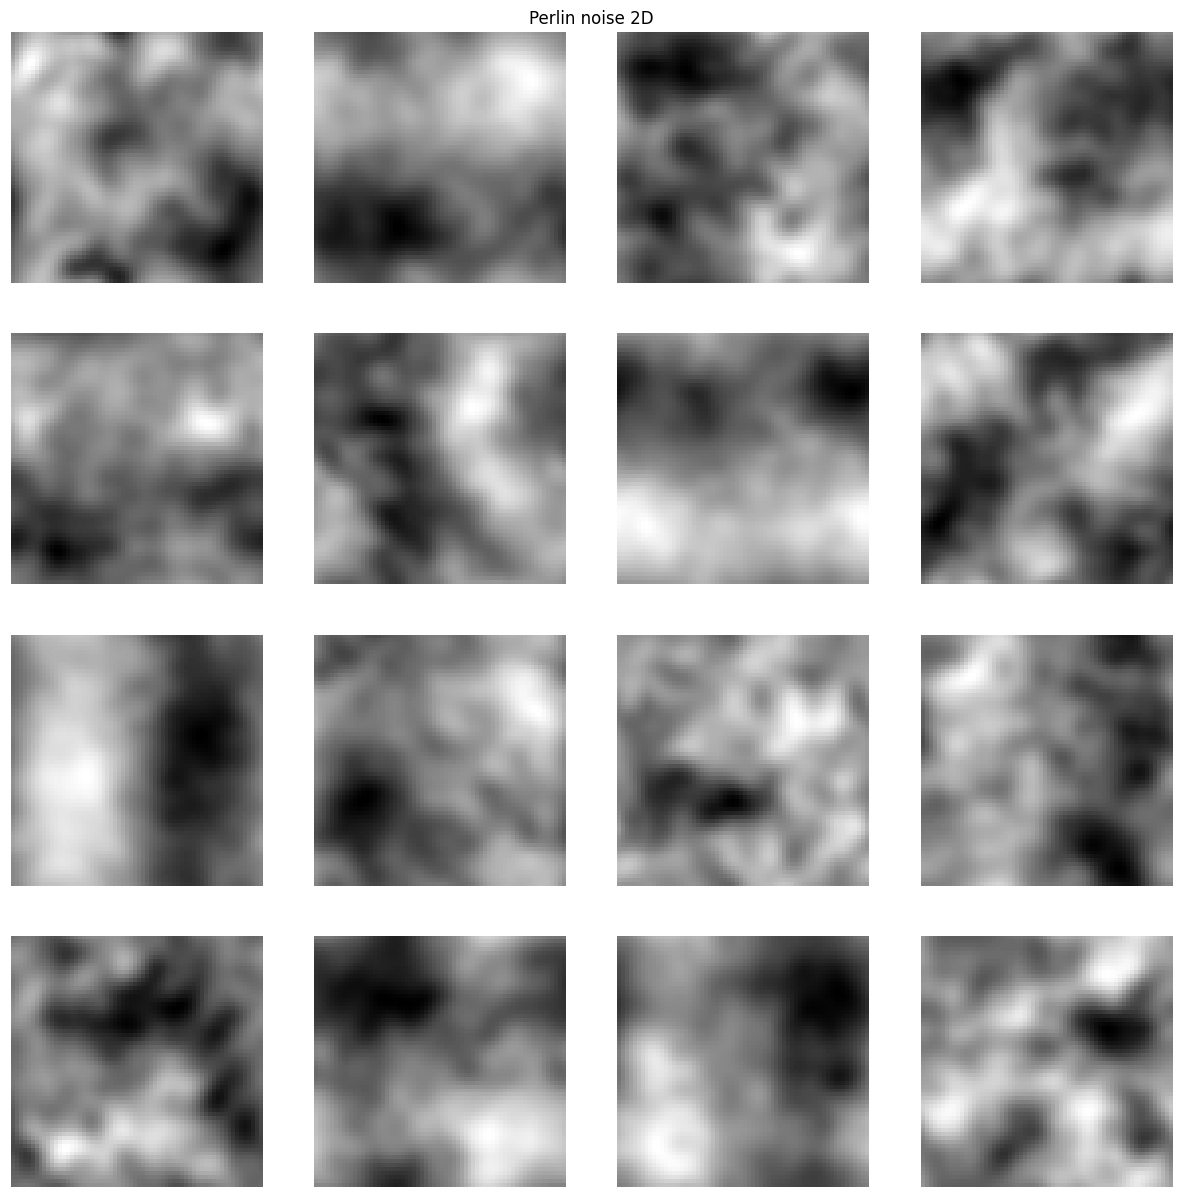

In [173]:
#plot 8 random samples
plt.figure(figsize=(15, 15))
plt.title('Perlin noise 2D')
plt.axis('off')

for i in range(16):
    plt.subplot(4, 4, i+1)
    img_temp = noise_2d[i].detach().cpu()
    #tile 4 times
    #img_temp = img_temp.repeat(2, 2)
    plt.imshow(img_temp, cmap='gray')
    plt.axis('off')

#plt.tight_layout()
plt.show()

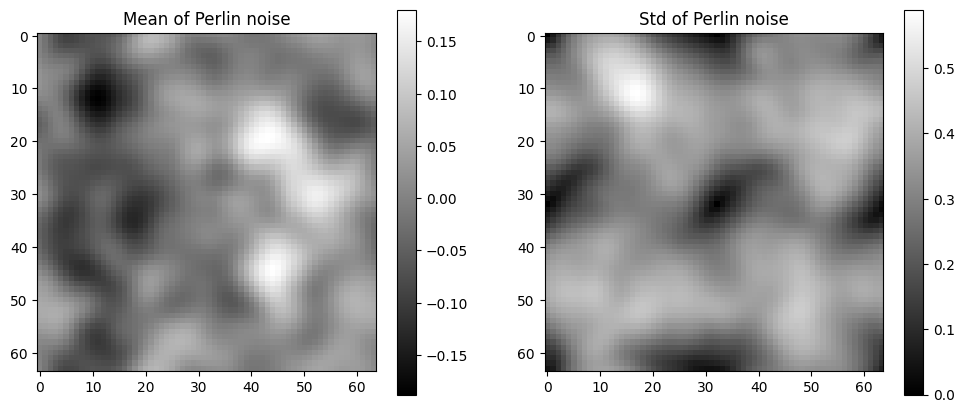

In [165]:
#What is the mean and std of the noise?
noise_mean = noise_2d.mean(0).cpu().numpy()
noise_std  = noise_2d.std(0).cpu().numpy()

#plot mean and std of noise
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(noise_mean, cmap='gray')
plt.colorbar()
plt.title('Mean of Perlin noise')
plt.subplot(122)
plt.imshow(noise_std, cmap='gray')
plt.colorbar()
plt.title('Std of Perlin noise')

# plt.axvline(max_resolution//4, color='blue')
# plt.axvline(3*max_resolution//4, color='blue')
# plt.axhline(max_resolution//4, color='blue')
# plt.axhline(3*max_resolution//4, color='blue')

plt.show()

## Jacobian

In [174]:
#use fwd_mode if z_dim << x_dim
jacobian = get_jacobian_general(z=z, fwd_mode=True, transform=transform_perlin_2d, print_info=True)
print('x_dim:', x_dim, 'z_dim:', z_dim, 'jacobian shape:', jacobian.shape)

Computing Jacobian with backward autodiff


  0%|          | 0/170 [00:00<?, ?it/s]

100%|██████████| 170/170 [00:02<00:00, 64.43it/s]

x_dim: 4096 z_dim: 170 jacobian shape: torch.Size([16, 170, 4096])


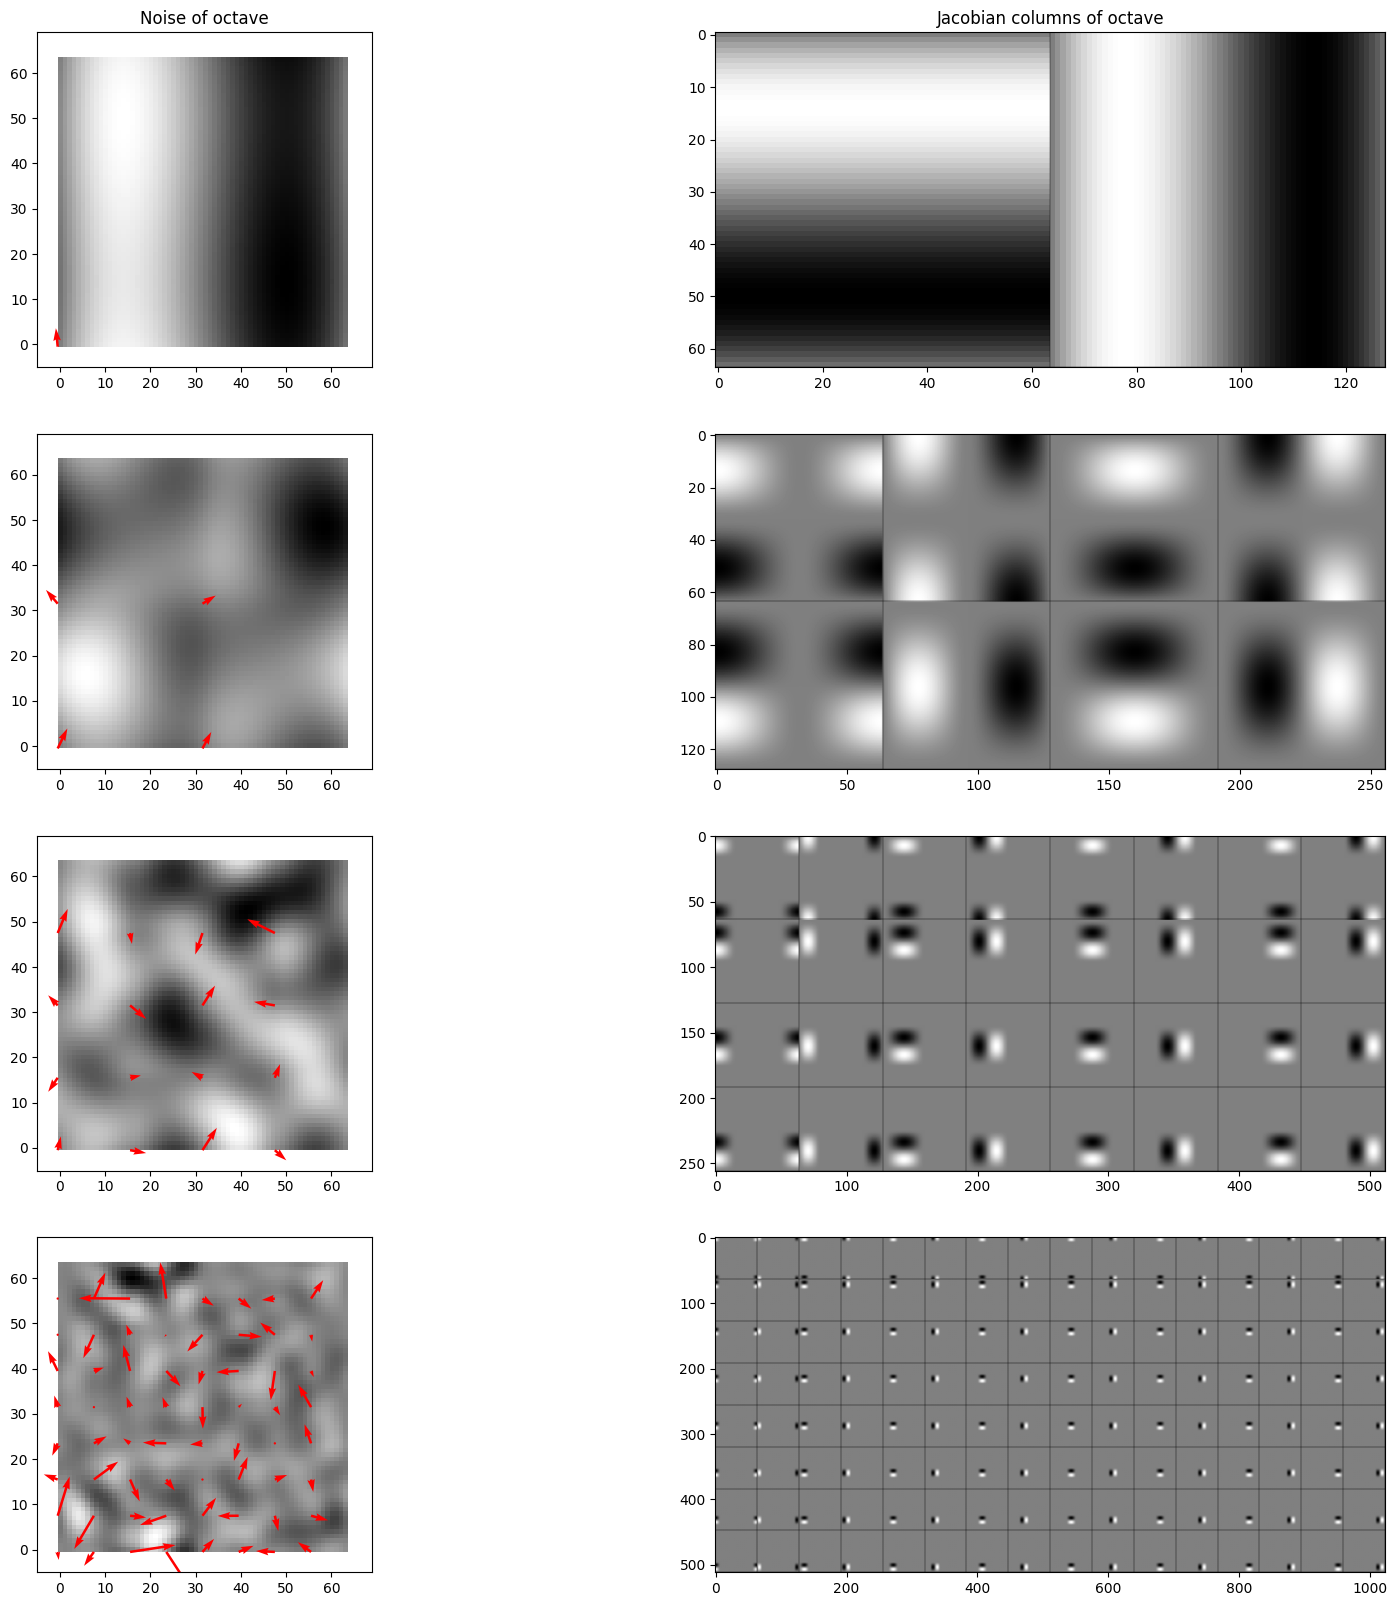

In [175]:
assert use_offsets == False, 'use_offsets not implemented for plotting yet'
idx = 0

plot_gradients_at_boundary = False

plt.figure(figsize=(20, 20))
start = 0

for k, gradients_temp in enumerate(gradients):
    plt.subplot(octaves, 2, 2*k+1)
    if k == 0:
        plt.title('Noise of octave')
    plt.xlim(-5, max_resolution+5)
    plt.ylim(-5, max_resolution+5)
    #plt.imshow(noise_2d[idx].reshape(max_resolution, max_resolution).detach().cpu().numpy(), label='x', cmap='gray')
    plt.imshow(noise_2d_scales[idx, ..., k].reshape(max_resolution, max_resolution).detach().cpu().numpy(), label='x', cmap='gray')
    grid_points = gradients_temp.shape[1] + periodic_boundary*1
    if periodic_boundary:
        gradients_temp = torch.cat((gradients_temp, gradients_temp[:,[0]]), dim=1)
        gradients_temp = torch.cat((gradients_temp, gradients_temp[:,:,[0]]), dim=2)
    #print(grid_points, gradients_temp.shape)
    grid = torch.stack(torch.meshgrid(torch.linspace(0, max_resolution, grid_points)-0.5, torch.linspace(0, max_resolution, grid_points)-0.5), dim=-1)
    if not plot_gradients_at_boundary:
        grid = grid[0:-1, 0:-1]
        gradients_temp = gradients_temp[:, 0:-1, 0:-1]
    #plot gradients
    plt.quiver(grid[..., 1], grid[..., 0], gradients_temp[idx, :, :, 0], gradients_temp[idx, :, :, 1], color='red')

    z_dim_temp = angle_shapes[k].numel()
    if use_gradients and not use_offsets:
        z_dim_temp *= 2
    elif use_offsets:
        z_dim_temp *= 3
    end = start + z_dim_temp
    

    plt.subplot(octaves, 2, 2*k+2)
    if k == 0:
        plt.title('Jacobian columns of octave')
    #combine jacobian into one image
    
    temp = jacobian[idx, start:end].reshape(end-start, max_resolution, max_resolution).detach().cpu().numpy()
    temp = temp.reshape(temp.shape[0]//(2*2**k), 2*2**k, max_resolution, max_resolution)
    #stack jacobian images
    temp = np.hstack(temp)
    temp = np.hstack(temp)
    plt.imshow(temp, cmap='gray')
    #plot gridlines to separate images
    for x_i in np.linspace(0, temp.shape[1], temp.shape[1]//max_resolution+1):
        plt.axvline(x_i-0.5, color='black', linewidth=0.3)
    for y_i in np.linspace(0, temp.shape[0], temp.shape[0]//max_resolution+1):
        plt.axhline(y_i-0.5, color='black', linewidth=0.3)
    start = end

## SVD

We can diagonalize the Jacobian for one sample (as perlin noise is a linear DGP) to obtain eigenvectors which form an orthonormal basis.

In [176]:
#take svd of one sample of the jacobian as it is identical for all samples
jacobian_one = jacobian[0]
svd = torch.svd(jacobian_one)
eigenvalues = svd.S.cpu().numpy()
eigenvectors = (svd.V.cpu().numpy() * np.sqrt(eigenvalues)).T

jac_vectors = jacobian_one.reshape(jacobian_one.shape[0], max_resolution, max_resolution).detach().cpu().numpy()

eig_vectors = eigenvectors.reshape(eigenvectors.shape[0], max_resolution, max_resolution)

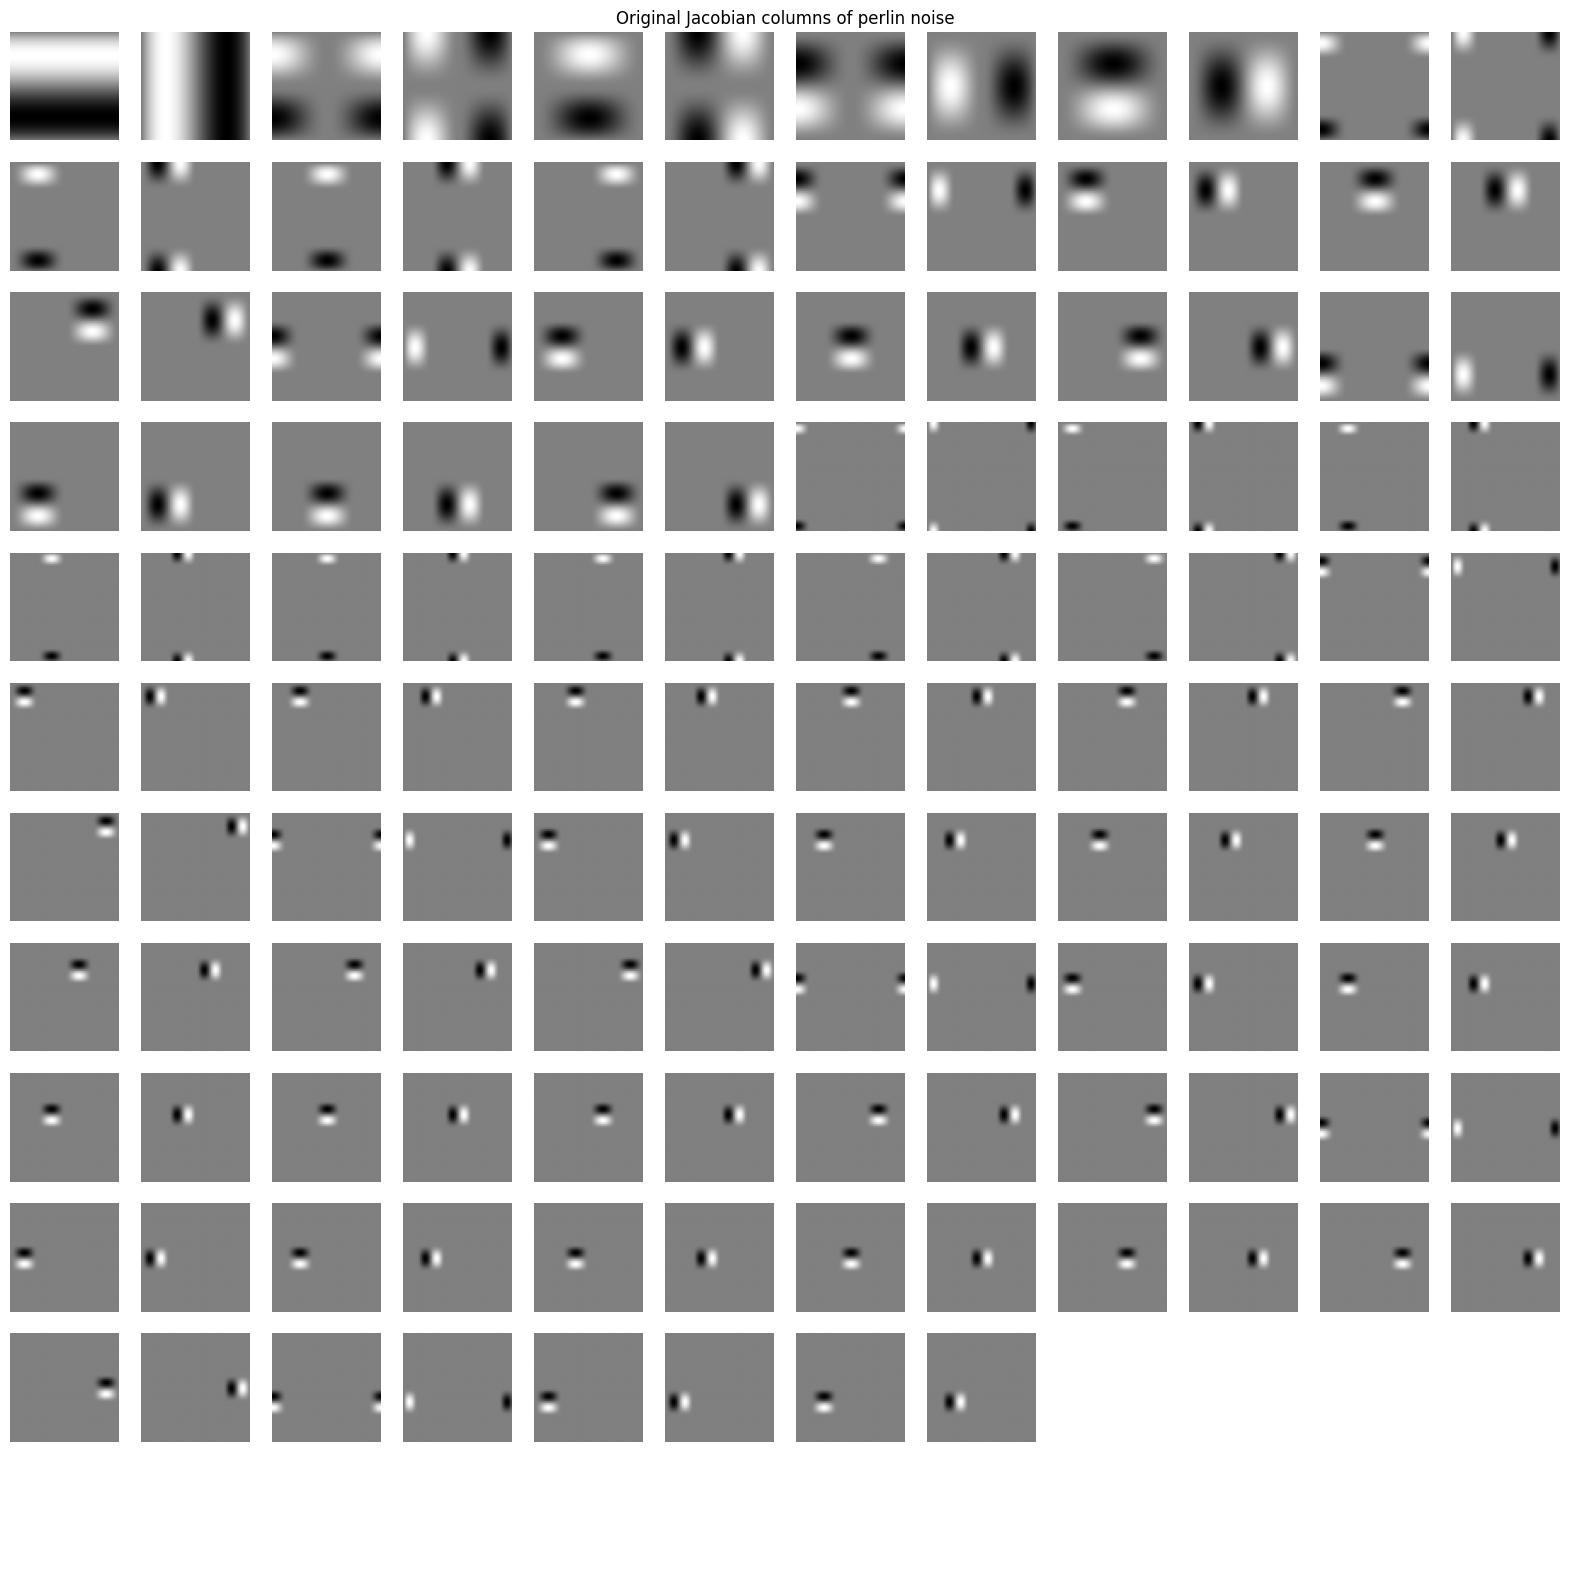

In [179]:
#plot jacobian vectors as images
plt.figure(figsize=(20, 20))
plt.title('Original Jacobian columns of perlin noise')
plt.axis('off')

z_dim_max = z_dim
if z_dim_max > 128:
    z_dim_max = 128
N_subplots_x = np.ceil(np.sqrt(z_dim_max)*1).astype(int)
N_subplots_y = np.ceil(z_dim_max/(np.sqrt(z_dim_max)*1)).astype(int)

for i in range(z_dim_max):
    plt.subplot(N_subplots_y, N_subplots_x, i+1)
    plt.imshow(jac_vectors[i], cmap='gray')
    plt.axis('off')
plt.show()

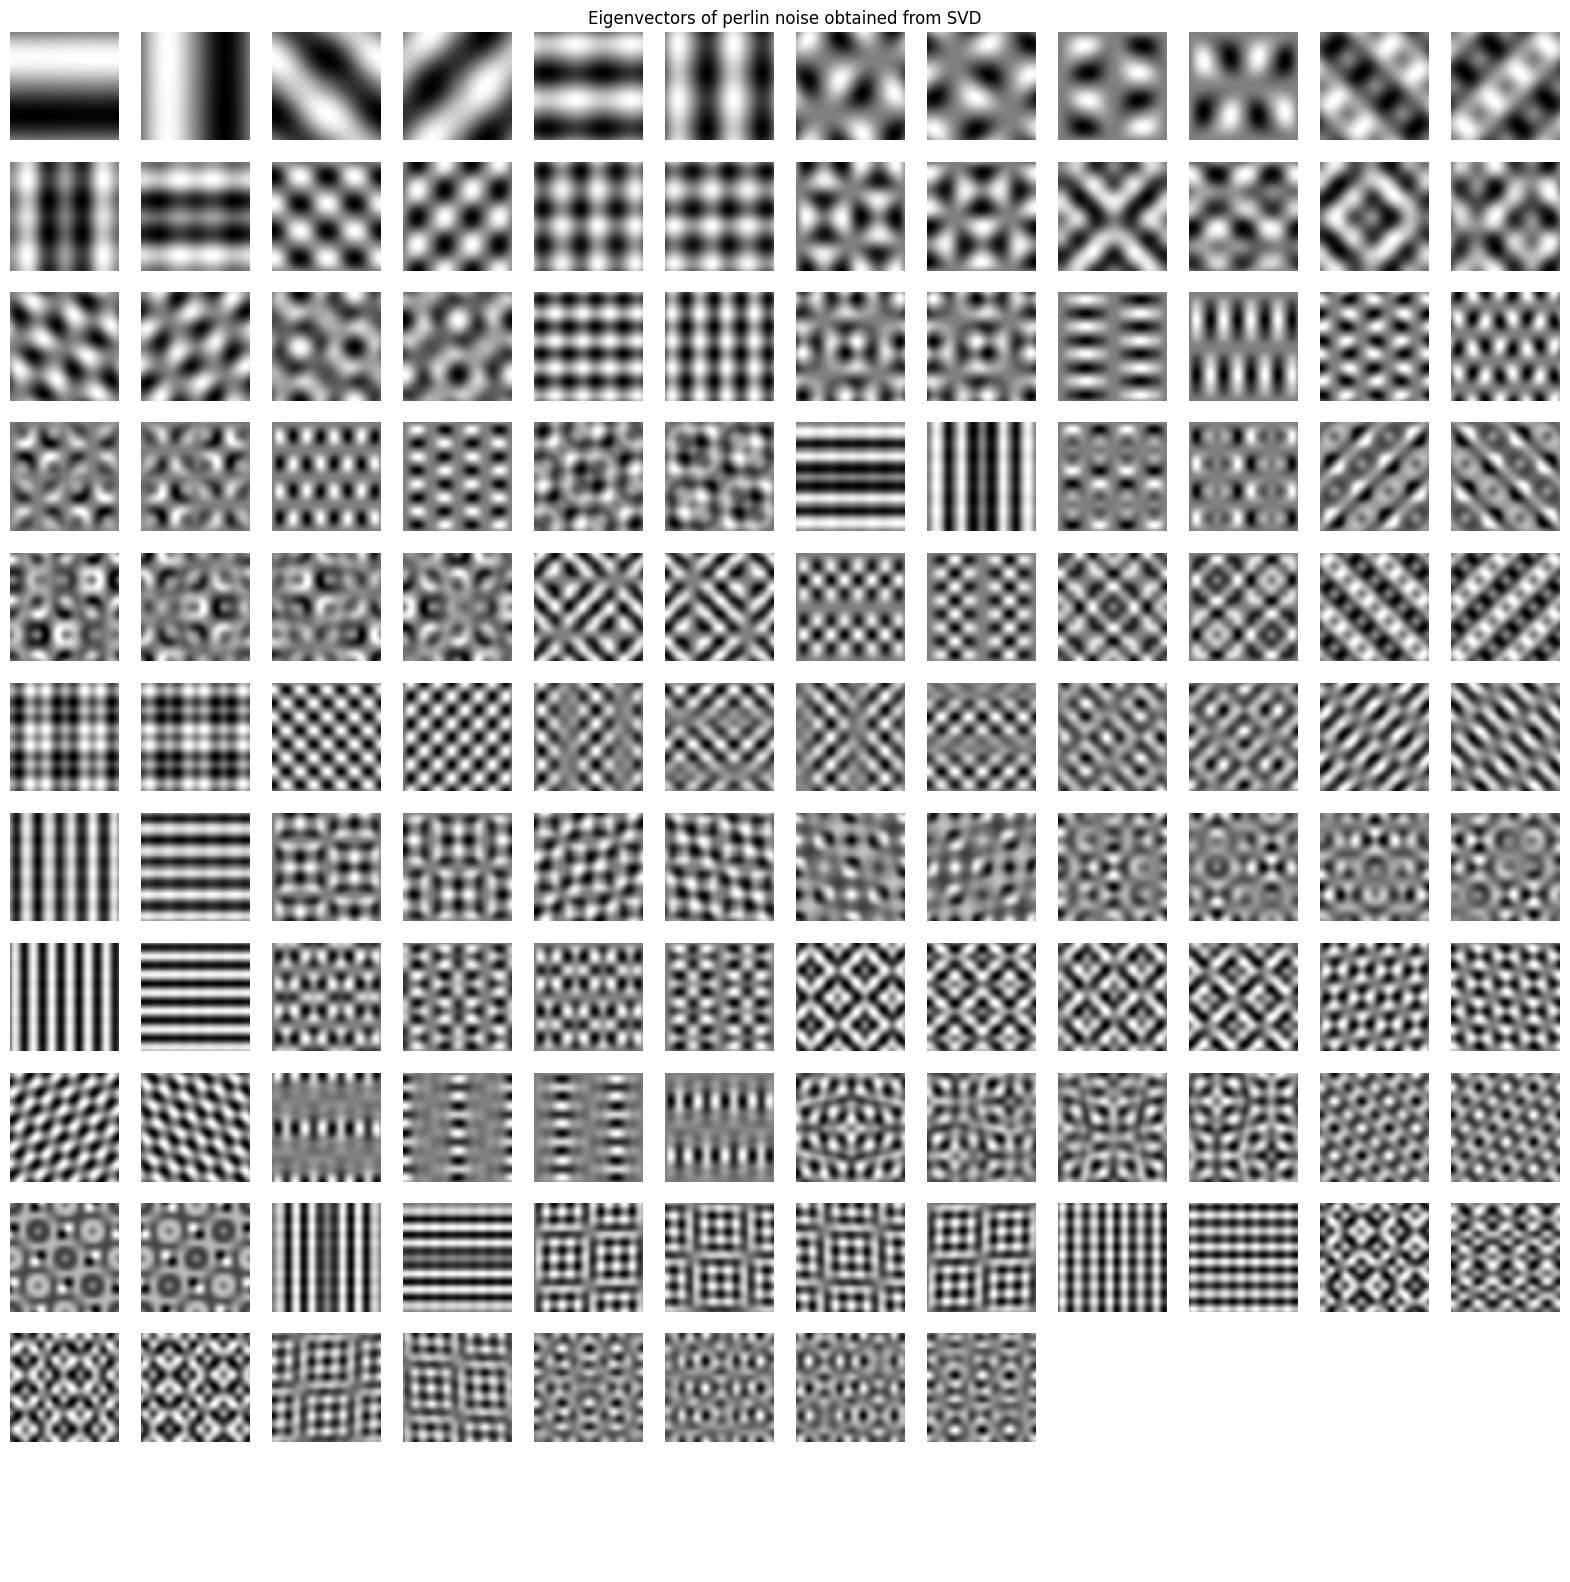

In [180]:
#plot eigenvectors as images
plt.figure(figsize=(20, 20))
plt.title('Eigenvectors of perlin noise obtained from SVD')
plt.axis('off')

z_dim_max = z_dim
if z_dim_max > 128:
    z_dim_max = 128
N_subplots_x = np.ceil(np.sqrt(z_dim_max)*1).astype(int)
N_subplots_y = np.ceil(z_dim_max/(np.sqrt(z_dim_max)*1)).astype(int)

for i in range(z_dim_max):
    plt.subplot(N_subplots_y, N_subplots_x, i+1)
    temp = eig_vectors[i]

    plt.imshow(temp, cmap='gray')
    plt.axis('off')

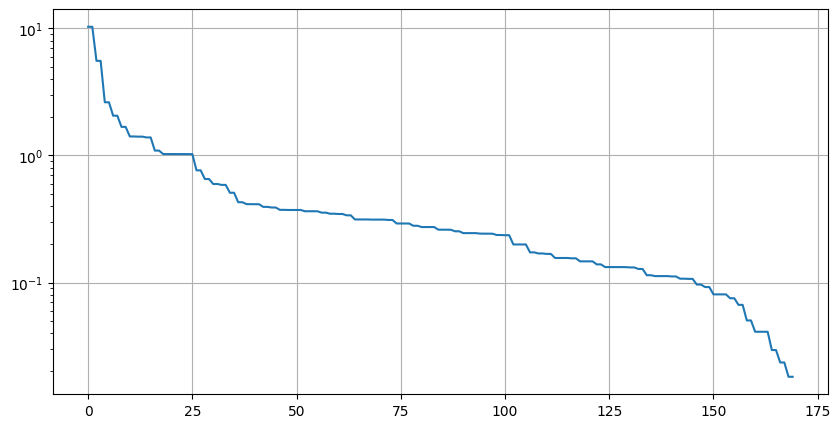

In [181]:
#plot eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(eigenvalues)
plt.yscale('log')
plt.grid()
plt.show()

## PCA

Similarly we can apply PCA on a large number of samples to obtain an approximate estimate of the diagonalized Jacobian 

In [182]:
gc.collect()
torch.cuda.empty_cache()

In [183]:
N_samples = 1024*16
z, gradients, angle_shapes, x_dim, z_dim = generate_latent_vectors(N_samples, min_freq, max_resolution, octaves, periodic_boundary, use_offsets)
#compute on cpu if not enough memory
#z = z.cpu()
print('x_dim:', x_dim, 'z_dim:', z_dim)

noise_2d = perlin_noise_2d_octaves(z, angle_shapes, max_resolution, (min_freq, min_freq), octaves=octaves, persistence=persistence, use_gradients=use_gradients, periodic_boundary=periodic_boundary, get_noise_scales=False, attenutate_noise=attenutate_noise, use_offsets=use_offsets)
noise_2d = noise_2d.detach()

x_dim: 4096 z_dim: 170


In [184]:
from sklearn.decomposition import PCA

noise_2d_flatten = noise_2d.reshape(N_samples, -1).cpu().numpy()

pca = PCA(n_components=z_dim)
pca.fit(noise_2d_flatten)

PCA(n_components=170)

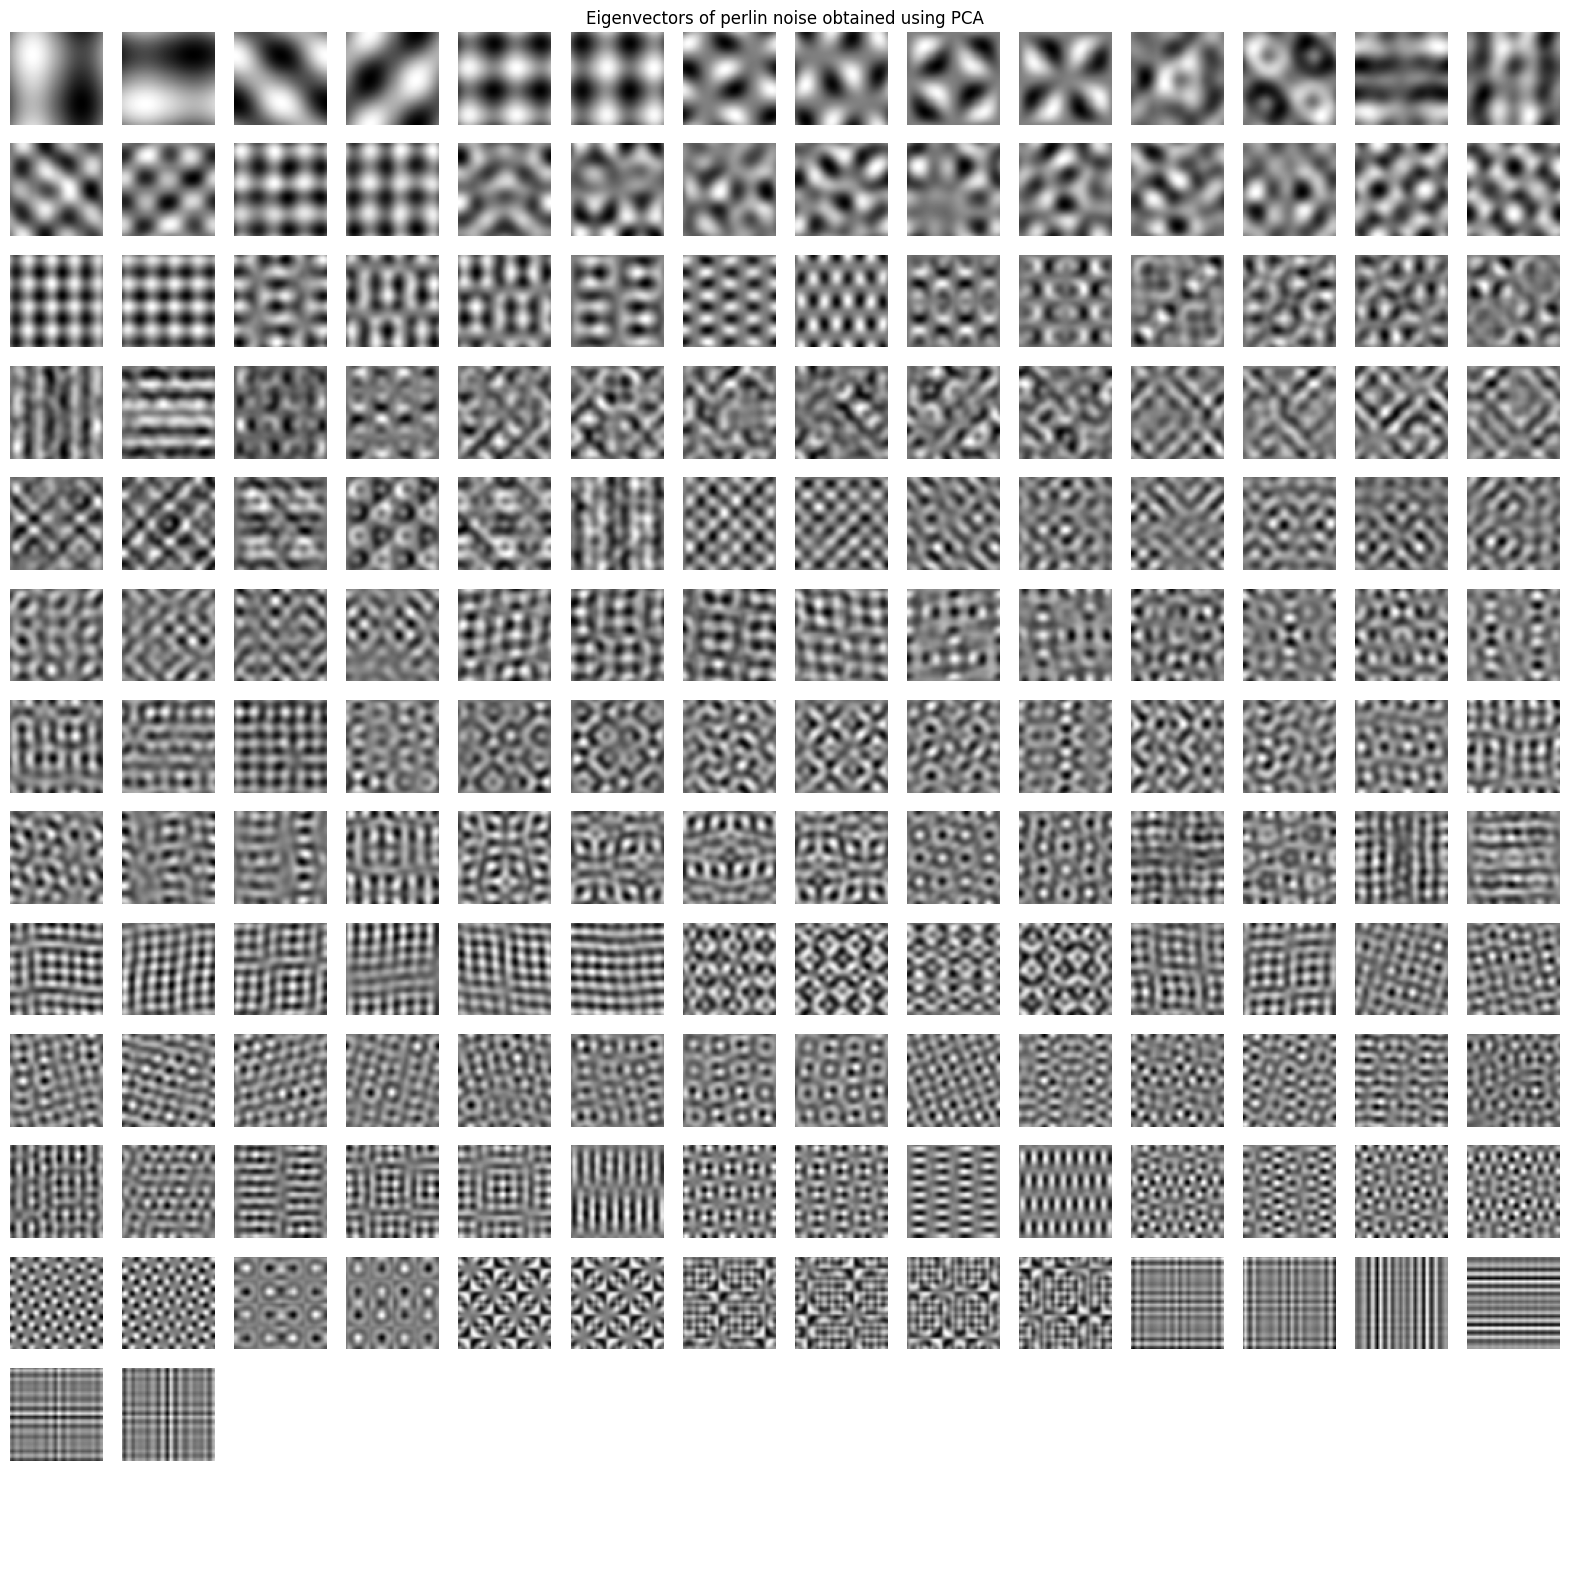

In [185]:
#plot pca_eigenvectors
eigenvectors_pca = pca.components_

plt.figure(figsize=(20, 20))
plt.title('Eigenvectors of perlin noise obtained using PCA')
plt.axis('off')
eigenvectors_temp = eigenvectors_pca.reshape(eigenvectors_pca.shape[0], max_resolution, max_resolution)

z_dim_temp = z_dim
if z_dim_temp > 256:
    z_dim_temp = 256
N_subplots_x = np.ceil(np.sqrt(z_dim_temp)*1).astype(int)
N_subplots_y = np.ceil(z_dim_temp/(np.sqrt(z_dim_temp)*1)).astype(int)

for i in range(z_dim_temp):
    plt.subplot(N_subplots_y, N_subplots_x, i+1)
    temp = eigenvectors_temp[i]

    plt.imshow(temp, cmap='gray')
    plt.axis('off')

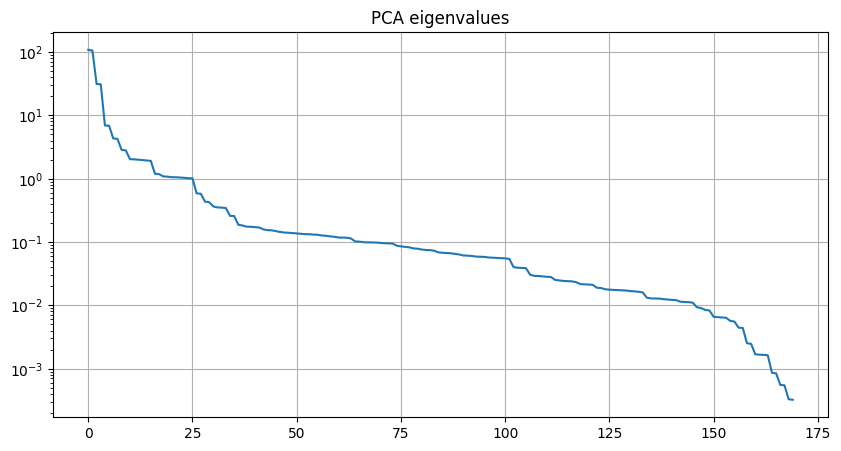

In [186]:
#plot pca eigenvalues
pca_eigenvalues = pca.explained_variance_

plt.figure(figsize=(10, 5))
plt.title('PCA eigenvalues')
plt.plot(pca_eigenvalues)
plt.yscale('log')
plt.grid()
plt.show()

The more sample we use, the closer the PCA-eigenvectors coincide with the (true) SVD-eigenvectors of the Jacobian

# Maximum Manifold Likelihood Training

## Init

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

In [ ]:
#NEED:
flow = #INN
N_dim = #number of latent dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
kwargs_loss = {
    'use_MML': True,
    'MML_mode': 'fwd_random',
    'lams_i': torch.zeros(N_dim).to(device),
    'lam_ortho': 0.1,
    'use_latent_sorting': False
}

## Training

Maximum Manifold Likelihood Training is new theory mainly from my Masters thesis "Manifold Density Learning by Manifold Maximum Likelihood Training of Normalizing Flows", see "6.2 Stochastic computation" for the code. For reference also see "Principal Manifold Flows" by Cunningham et al. (https://arxiv.org/abs/2202.07037).

In [188]:
def get_MML_loss(flow, x, kwargs_loss):
    use_MML             = kwargs_loss['use_MML']
    MML_mode            = kwargs_loss['MML_mode']
    lams_i              = kwargs_loss['lams_i'] #torch.zeros(N_dim).to(device)
    lam_ortho           = kwargs_loss['lam_ortho']
    use_latent_sorting  = kwargs_loss['use_latent_sorting']

    assert MML_mode in ['fwd_random', 'fwd_full', 'bwd_full', 'bwd_random'], 'MML_mode not implemented'

    z, ljd = flow(x, rev=False)
    N_dim = z.shape[1]

    NLL_pz = 0.5*z**2

    latent_sort = torch.arange(0, N_dim).to(device)

    if not use_MML: #use Maximum Likelihood training
        NLL = (NLL_pz.sum(-1) - ljd).sum() / x.numel()
        loss = NLL
        MI = torch.tensor(0.0).to(device) # we don't compute MI for normal training
    else: #use Maximum Manifold Likelihood training
        with torch.no_grad():
            NLL = (NLL_pz.sum(-1) - ljd).sum() / x.numel()
        if MML_mode == 'fwd_random': #Random Jacobian computation
            e = torch.multinomial(torch.ones(N_dim), batchsize, replacement=True).to(device) #sample random indices
            if N_dim < batchsize: #if batchsize is larger than N_dim, then we can compute the jvp once for each dimension
                e[0:N_dim] = torch.arange(0, N_dim).to(device)
            e = nn.functional.one_hot(e, num_classes=N_dim).to(z.dtype) #create one-hot-vector

            with dual_level(): #compute jvp
                dual_z = make_dual(z, e)
                dual_x, _ = flow(dual_z, rev=True)
                _, x_jvp = unpack_dual(dual_x)
            x_jvp = x_jvp.reshape(batchsize, -1) #reshape jpv to [B x D]
            ljd_inv_i = 1/2*(torch.log(torch.sum((x_jvp)**2, axis=-1)))[:,None] #[B x D]
            M = torch.sum(e, dim=0) #[D]
            m = e * batchsize/M[None,:] #[B x D]
            M = M.to(torch.bool) #[D]

            NLL_i = torch.sum(M[None,:]*NLL_pz + m[:,M]*ljd_inv_i, 0)

            with torch.no_grad():
                MI = NLL_i.mean()/ x.shape[0] - loss_NLL.mean().detach()
            
            if use_latent_sorting: #sort the latent dimensions by the magnitude of the estimated manifold entropy NLL_i
                NLL_i, idx_sort = torch.sort(NLL_i, descending=True)
                latent_sort = idx_sort #latent_sorting[idx_sort]
                NLL_pz_temp = NLL_pz[:, idx_sort]
                
            loss_NLL_temp = torch.sum(torch.sum((1-lam_ortho)*NLL_pz_temp, -1) - (1-lam_ortho)*ljd, 0)
            loss_NLL_i = (lam_ortho + lams_i[0,:])*NLL_i
            loss = (loss_NLL_temp + loss_NLL_i.sum()) / x.numel()
        elif MML_mode == 'fwd_full': #Full Jacobian computation
            grad_xz = []
            x_rec, _ = flow(z, rev=True)
            for j in range(N_dim):
                grad_xz.append(grad(x_rec[:, j].sum(), z, create_graph=True)[0])
            grad_xz = torch.stack(grad_xz, axis=2)  #Jacobian of the decoder
            ljd_inv_i = 1/2*torch.log(torch.sum(grad_xz**2, axis=-1))

            #lams_i = torch.zeros(N_dim).to(device)

            loss_NLL_full = torch.sum(NLL_pz.sum(-1) - ljd, 0)
            loss_NLL_i = torch.sum(NLL_pz + ljd_inv_i, 0)

            loss = ((1-lam_ortho)*loss_NLL_full + ((lam_ortho+lams_i)*loss_NLL_i).sum()) / x.numel()
            with torch.no_grad():
                MI = (loss_NLL_full - loss_NLL_i).sum() / x.numel()
        elif MML_mode == 'bwd_full': #Implementation from "Principal Manifold Flows" paper but with full Jacobian
            grad_zx = []
            for j in range(N_dim):
                grad_zx.append(grad(z[:, j].sum(), x, create_graph=True)[0])
            grad_zx = torch.stack(grad_zx, axis=1) #Jacobian of the encoder
            #print(grad_zx.shape)
            ljd_i = torch.log(torch.sum(grad_zx**2, axis=-1))

            loss_NLL = (NLL_pz.sum(-1) - ljd).sum()
            loss_MI_i = (1/2*torch.sum(ljd_i) - ljd.sum(0))
            loss = (loss_NLL_temp + lam_ortho*loss_MI_i) / x.numel()
            
            with torch.no_grad():
                MI = loss_MI_i / x.numel()
        elif MML_mode == 'bwd_random': #Implementation from "Principal Manifold Flows" paper, could be improved...
            grad_zx = []
            j = torch.randint(0, N_dim, (1,)).to(device)
            grad_zx.append(grad(z[:, j].sum(), x, create_graph=True)[0])
            grad_zx = torch.stack(grad_zx, axis=1) #Approximate Jacobian of the encoder
            #print(grad_zx.shape)
            ljd_i = N_dim*torch.log(torch.sum(grad_zx**2, axis=-1))

            loss_NLL_temp = torch.sum(0.5*torch.sum(z**2, -1) - ljd, 0)
            loss_NLL_i = (1/2*torch.sum(ljd_i) - ljd.sum(0))
            loss = (loss_NLL_temp + lam_ortho*loss_NLL_i) / x.numel()

            with torch.no_grad():
                MI = loss_NLL_i / x.numel()
    
    #loss is used for backpropagation
    #NLL and MI are used for monitoring
    #latent_sort gives a sorting of the latent dimensions

    return loss, NLL, MI, latent_sort

Maximum Manifold Likelihood training (use_MML):

We need the Jacobian of the decoder, using forward mode differentiation (fwd):
- fwd_random: computes the Jacobian of the decoder for a random latent dimension, one per batch sample - 2.5-3 times slower than ML-training
- fwd_full:   computes the full Jacobian of the decoder - scales linearly with the number of latent dimensions (very slow)

The implementation from the "Principal Manifold Flows" paper uses the Jacobian of the encoder as an approximation and thus uses backward mode differentiation:
- bwd_random: computes the Jacobian of the encoder for a random latent dimension for all batch samples - unbiased estimator - faster than normal
- bwd_full:   computes the full Jacobian of the encoder and scales linearly with the number of latent dimensions (very slow and not correct)

## Evaluation

See paper "Analyzing Generative Models by Manifold Entropic Metrics" by me (https://arxiv.org/abs/2410.19426) for reference.

In [ ]:
#NEED:
flow = #trained INN
N_dim = #number of latent dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
kwargs_data = {
    'N_dim': N_dim,
    'device': device,
    'dtype': torch.float32,
    'get_data' : None,
    'data_mean': 0.0,
    'data_std': 1.0,
}

In [192]:
def get_decoder_jac(model, kwargs_data, N_samples=1000, use_samples=True, z_input=None, x_input=None, print_info=True):
    N_dim = kwargs_data['N_dim']
    device = kwargs_data['device']

    if use_samples: # compute jacobian for data samples, need to transform them first to latent space via the encoder of the model
        get_data = kwargs_data['get_data']
        data_mean = kwargs_data['mean']
        data_std = kwargs_data['std']
        x = get_data(kwargs_data, N_samples)
        x = x.to(device=device)
        x = (x - data_mean) / data_std
        z, _ = model(x, rev=False)
    else: # compute jac for random latent vectors
        z = torch.randn(N_samples, N_dim).to(device=device)
        z.requires_grad = True
    
    if z_input is not None:
        z = z_input
        N_samples = z.shape[0]
    elif x_input is not None:
        x = x_input
        N_samples = x.shape[0]
        x = (x - data_mean) / data_std
        z, _ = model(x, rev=False)
        z = z.detach().requires_grad_(True)

    if print_info: #use tqdm
        update_func = lambda x: tqdm(x)
    else:
        update_func = lambda x: x

    full_jac_array = torch.zeros((N_samples, N_dim, N_dim)).to(device=device)
    if print_info:
        print('Computing Jacobian with backward autodiff')
    
    x, ljd = model(z, rev = True) # Run the model in reverse to obtain generated samples and ljd
    
    x = x * data_std + data_mean # renormalize x as we compute the jacobian in the original data space before normalization
    for i in update_func(range(N_dim)): #loop through all dims of x
        x_grad = grad((x).reshape(N_samples, -1)[:,i].sum(), z, create_graph=True)[0]# 
        full_jac_array[:,:,i] = x_grad.detach().to(device=device)
        del x_grad

    return full_jac_array.detach(), ljd.detach().to(device=device), z.detach().to(device=device), x.detach().to(device=device)

In [193]:
def get_manifold_entropy(kwargs_data, full_jac_array, ljd_array, z_array, use_latent_std=False, print_info=True):
    N_dim = kwargs_data['N_dim']
    #device = kwargs_data['device']
    #dtype = kwargs_data['dtype']

    #data_mean = kwargs_data['data_mean']
    data_std = kwargs_data['data_std']

    NLL_pz = (0.5*z**2).mean(0)

    H_full = (ljd_array + N_dim*torch.log(data_std) + NLL_pz.sum(0)).mean() #we add log(data_std) to the entropy as we compute the entropy in the original data space
    H_i = torch.zeros((N_dim), dtype=torch.float32)

    update_func = lambda x: x
    if print_info:
        update_func = lambda x: tqdm(x)

    for i in update_func(range(N_dim)):
        H_i[i] = torch.mean(1/2*torch.log(torch.sum(full_jac_array[:,i,:]**2, -1)), -1) + NLL_pz[i]

    latent_sort = torch.argsort(H_i, descending=True)
    
    return H_i, H_full, latent_sort

In [ ]:
def get_manifold_pairwise_mutual_information(jac_1, jac_2, N_dim_max=N_dim, dtype=torch.float64, device='cpu'): #computes the manifold mutual information between two jacobians
    assert jac_1.shape == jac_2.shape

    jac_1 = jac_1.to(device=device).to(dtype=dtype)
    jac_2 = jac_2.to(device=device).to(dtype=dtype)

    if (jac_1 == jac_2).all():
        symmetric = True
    else:
        symmetric = False

    MPMI_ij = torch.zeros((10, N_dim_max, N_dim_max), dtype=dtype).to(device=device)

    if jac_1.dim() == 3:
        jac_1 = jac_1.unsqueeze(0)
    if jac_2.dim() == 3:
        jac_2 = jac_2.unsqueeze(0)
    
    assert jac_1.dim() == 4

    #precompute jac_det_i
    jac_det_1i = torch.log(torch.sum(jac_1[:,:,:,:]**2, -1))
    jac_det_2i = torch.log(torch.sum(jac_2[:,:,:,:]**2, -1))

    for i in tqdm(range(N_dim_max)):
        second_range = range(N_dim_max) if not symmetric else range(i+1, N_dim_max)
        idx = torch.tensor([i,0])
        for j in second_range:

            idx = torch.tensor([i,j])#.to(device='cuda')
            submatrix = torch.cat((jac_1[:,:,idx[0],:].unsqueeze(2), jac_2[:,:,idx[1],:].unsqueeze(2)), 2)
            GTG = torch.einsum('xyij, xykj -> xyik', submatrix, submatrix)

            jac_det_12 = GTG[...,0,0]*GTG[...,1,1] - GTG[...,0,1]*GTG[...,1,0]
            jac_det_12 = torch.log(jac_det_12)

            jac_det_1 = jac_det_1i[:,:,idx[0]]
            jac_det_2 = jac_det_2i[:,:,idx[1]]
            if jac_det_1.isnan().any() or jac_det_2.isnan().any() or jac_det_12.isnan().any():
                print('Is nan!')
                print(jac_det_1)
                print(jac_det_2)
                print(jac_det_12)
                return

            MPMI_ij[:,i,j] = - 1/2*torch.mean(jac_det_12 - jac_det_1 - jac_det_2, -1).to(device=device).to(dtype=dtype)

    MPMI_ij = MPMI_ij.mean(0)
    return MPMI_ij.to(device=device).to(dtype=dtype)

In [ ]:
#first compute the full Jacobian matrix
jac, ljd, z, x = get_decoder_jac(flow, kwargs_data, N_samples=1000, use_samples=True, print_info=True)
#compute the manifold entropy
H_i, H_full, latent_sort = get_manifold_entropy(kwargs_data, jac, ljd, z, use_latent_std=False, print_info=True)
#sort the latent dimensions by the entropy
H_i_sort = H_i[latent_sort].cpu().detach().numpy()
#compute Total Correlation
TC = (H_i.sum() - H_full)/N_dim
print('Total Corelation between all latent dimensions (normalized):', TC.item())

In [ ]:
#plot the sorted manifold entropy to obtain entropy spectrum
plt.figure(figsize=(8, 4))
plt.plot(H_i_sort, label='Manifold Entropy (sorted)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#compute the manifold pairwise mutual information matrix (MPMI)
jac_sorted = jac[:, latent_sort, :]
MPMI_ij = get_manifold_pairwise_mutual_information(jac_sorted, jac_sorted)
MPMI_ij = MPMI_ij.cpu().numpy()

In [ ]:
#plot the MPMI matrix as a heatmap to measure correlations between latent dimensions
plt.figure(figsize=(8, 8))
plt.title('Manifold Pairwise Mutual Information')
plt.imshow(MPMI_ij, cmap='inferno')
plt.colorbar()
plt.show()